In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
# Lectura sin formato
data = pd.read_csv('AirPassengers.csv')
print(data.head())
print('\n Data Types:')
print(data.dtypes)

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

 Data Types:
Month          object
#Passengers     int64
dtype: object


In [2]:
# Formato
import datetime
dateparse = lambda dates: datetime.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
print(data.head())
# Serie temporal
ts = data['#Passengers'] 
print(ts.head(10))
# Seleccionar un elemento
print(ts['1949-01-01'])
print(ts[datetime.datetime(1949,1,1)])
# Seleccionar un rango de valores correlativos
print(ts['1949-01-01':'1949-05-01'])
print(ts[:'1949-05-01'])
# Rango de fechas
print(ts['1949'])

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121
Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: #Passengers, dtype: int64
112
112
Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64
Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64
Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: #Passengers, dtype: int64


C:\Users\tavin\AppData\Local\Temp\ipykernel_16892\1855250861.py:4: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)


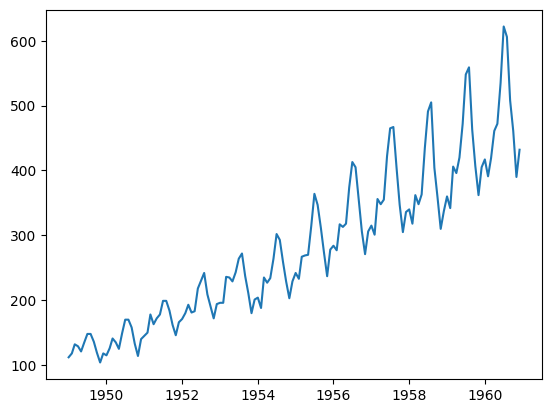

In [3]:
plt.plot(ts)
plt.show()

1) Determinar los parámetros del modelo ARIMA con los que se obtenga el mejor ajuste en la serie AirPassengers. Valida el modelo en un periodo comprendido entre los años1958, 1959 y 1960 (es decir, no deben emplearse los datos de estostresaños para aprender los parámetros del modelo)

In [4]:
import statsmodels.api as sm
import itertools
import numpy as np
import pandas as pd
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error
import math

# Suprimir los warnings específicos
warnings.filterwarnings("ignore", category=UserWarning, message="Non-stationary starting seasonal autoregressive")
warnings.filterwarnings("ignore", category=ConvergenceWarning, message="Maximum Likelihood optimization failed to converge")
warnings.filterwarnings("ignore", category=ConvergenceWarning, message="Non-stationary starting autoregressive parameters")

# Asegúrate de que tu índice de fecha tenga la frecuencia correcta (mensual en este caso)
data.index.freq = 'MS'  # Establece la frecuencia mensual si tus datos son mensuales

# Dividir los datos en entrenamiento y validación
train_data = data[data.index.year < 1958]
valid_data = data[data.index.year >= 1958]

y = data['#Passengers']

# Dividir los datos en entrenamiento y validación (también para la variable y)
y_train = y[:'1957-12-31']
y_valid = y['1958-01-01':]

# Definir los rangos para p, d y q
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

# Definir los rangos para P, D, Q y m (estacionales)
P = D = Q = range(0, 2)
m = [12]  # Número de períodos estacionales (12 para mensual)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]

# Imprimir ejemplos de combinaciones de parámetros
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

# Búsqueda de los mejores parámetros usando AIC
best_aic = np.inf
best_params = None

# Búsqueda de los mejores parámetros SARIMAX
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_invertibility=False)
            results = mod.fit(disp=False)
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, param_seasonal)
        except Exception as e:
            print(f'Error en ARIMA{param}x{param_seasonal}12: {e}')
            continue

# Ajuste final del modelo con los mejores parámetros
final_model = sm.tsa.statespace.SARIMAX(y_train,
                                       order=best_params[0],
                                       seasonal_order=best_params[1],
                                       enforce_invertibility=False)
final_results = final_model.fit(disp=False)

# Realizar predicciones sobre los datos de validación
predictions = final_results.forecast(steps=len(y_valid))

# Mostrar las predicciones y el valor real
print(f'\nPredicciones para el periodo de validación:')
print(f'Predicciones: {predictions}')
print(f'Valores reales: {y_valid.values}')

# Evaluación del modelo (por ejemplo, calculando RMSE)
rmse = math.sqrt(mean_squared_error(y_valid, predictions))
print(f'\nRMSE: {rmse}')

# Mostrar los mejores parámetros encontrados
print(f'\nMejores parámetros: {best_params} con AIC: {best_aic}')

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1497.7366324421453
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1395.199201988693
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:951.210659060875
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:911.4984239199836
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1121.916216171111
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1082.869658604274
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:862.1980043940844
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:841.1799531944534
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1357.7177148131234
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1255.7607754614155
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:866.6327480005609
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:845.8588807159769
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1023.3531479044112
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1059.2543102048637
ARIMA(0, 0, 1)x(1, 1, 0, 12)1

c:\Users\tavin\Downloads\Practica 7\myenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\tavin\Downloads\Practica 7\myenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:940.132287034184
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:716.9264331041944
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:716.5564529544592


c:\Users\tavin\Downloads\Practica 7\myenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\tavin\Downloads\Practica 7\myenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:834.6459457023493
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:834.4905622805962
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:716.4564229257521
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:719.8659468271543
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:1005.5521422142884
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:936.7227472281436
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:714.4806933706957
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:715.0979489561018
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:834.4419604706289
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:834.9568680591193
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:714.8316441038971
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:715.8598781361873
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:994.8201922501468
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:922.2648502856888
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:704.0011679025909
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:704.4718578848691
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:820.6860885694472
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:821.165366869126
ARIMA(1, 1

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2411      0.091     -2.648      0.008      -0.420      -0.063
sigma2        92.7499     13.439      6.902      0.000      66.410     119.090


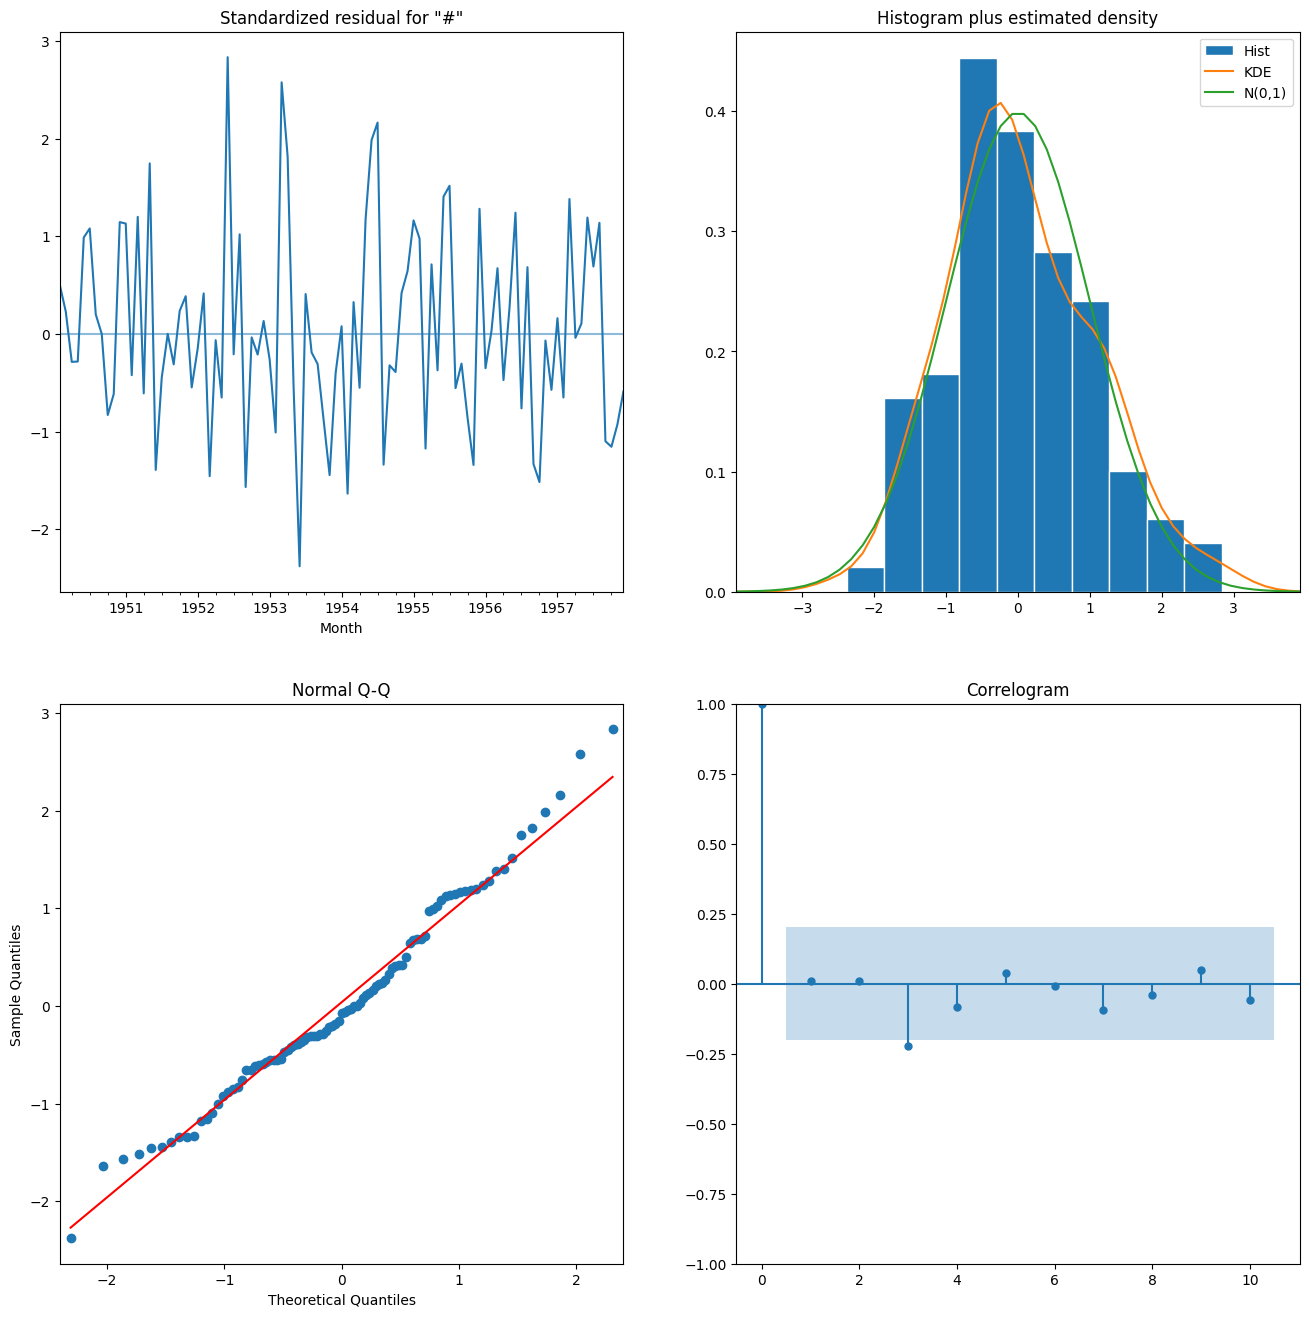

In [5]:
# Entrenar el modelo con los mejores parámetros
best_mod = sm.tsa.statespace.SARIMAX(y_train,
                                     order=best_params[0],
                                     seasonal_order=best_params[1],
                                     enforce_invertibility=False)
best_results = best_mod.fit()
print(best_results.summary().tables[1])
best_results.plot_diagnostics(figsize=(16, 16))
plt.show()

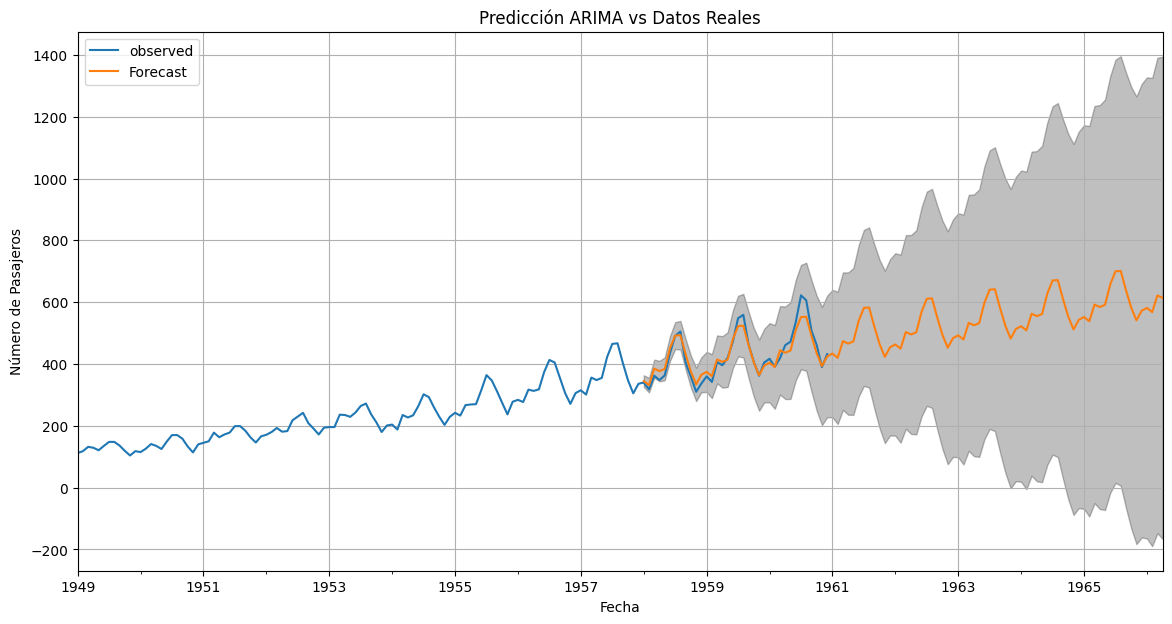

In [6]:
# Predicción a múltiples pasos
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('#Passengers')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Número de Pasajeros')
plt.title('Predicción ARIMA vs Datos Reales')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
# Evaluación de la predicción ARIMA
y_truth = y['1958-01-01':]
predicciones_arima = pred_uc.predicted_mean[y_truth.index]

mse = ((predicciones_arima - y_truth) ** 2).mean()
rele = (np.abs(predicciones_arima - y_truth)/y_truth*100).mean()
print('Error cuadrático medio ARIMA {}'.format(round(mse, 2)))
print('Raíz cuadrada de ECM ARIMA {}'.format(round(np.sqrt(mse), 2)))
print('Error porcentual medio ARIMA {}'.format(round(rele, 2)))

Error cuadrático medio ARIMA 536.28
Raíz cuadrada de ECM ARIMA 23.16
Error porcentual medio ARIMA 4.14


2. Ajustar el modelo Holt-Winters a esta serie y comparar sus resultados en el mismo 
conjunto de test

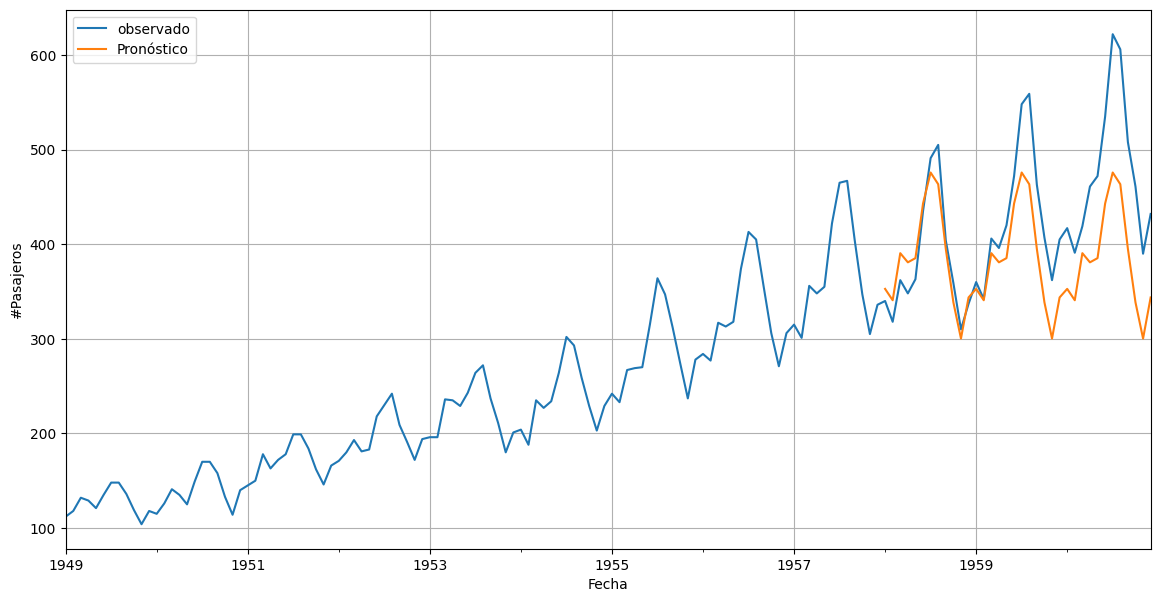

Error cuadrático medio Holt-Winters 4295.53
Raíz cuadrada de ECM Holt-Winters 65.54
Error porcentual medio Holt-Winters 11.28


In [8]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Dividir datos en entrenamiento y validación
train_data = data[data.index.year < 1958]
valid_data = data[data.index.year >= 1958]

y = data['#Passengers']

# Dividir datos en entrenamiento y validación
y_train = y[:'1957-12-31']
y_valid = y['1958-01-01':]

# Ajustar el modelo Holt-Winters
model = ExponentialSmoothing(y_train, seasonal='add', seasonal_periods=12)
model_fit = model.fit()

# Predicción a múltiples pasos
pred_uc = model_fit.forecast(steps=len(y_valid))

# Graficar la predicción
ax = y.plot(label='observado', figsize=(14, 7))
pred_uc.plot(ax=ax, label='Pronóstico')
ax.set_xlabel('Fecha')
ax.set_ylabel('#Pasajeros')
plt.legend()
plt.grid(True)
plt.show()

# Evaluación de la predicción Holt-Winters
y_truth = y['1958-01-01':]
predicciones_hw = pred_uc[y_truth.index]

mse = ((predicciones_hw - y_truth) ** 2).mean()
rele = (np.abs(predicciones_hw - y_truth)/y_truth*100).mean()
print('Error cuadrático medio Holt-Winters {}'.format(round(mse, 2)))
print('Raíz cuadrada de ECM Holt-Winters {}'.format(round(np.sqrt(mse), 2)))
print('Error porcentual medio Holt-Winters {}'.format(round(rele, 2)))

3) Ajustar Prophet a los mismos datos y comparar los resultados (la parte de series múltiples no es aplicable a este problema)

c:\Users\tavin\Downloads\Practica 7\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
02:51:02 - cmdstanpy - INFO - Chain [1] start processing
02:51:02 - cmdstanpy - INFO - Chain [1] done processing


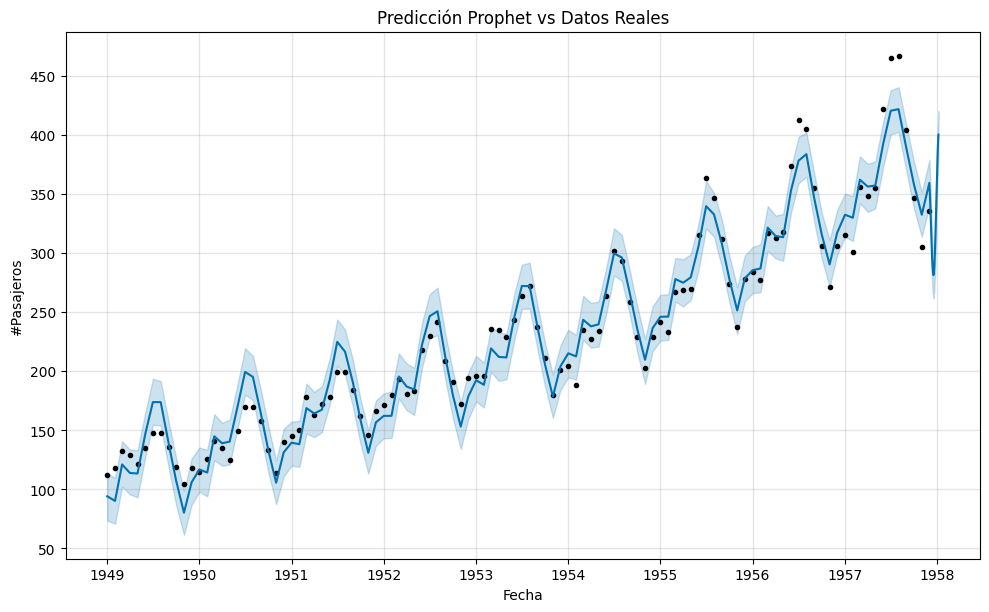

Error cuadrático medio Prophet 1019.78
Raíz cuadrada de ECM Prophet 31.93
Error porcentual medio Prophet 9.39


In [9]:
from prophet import Prophet
# Preparar los datos para Prophet
df = data.reset_index()
df.columns = ['ds', 'y']

# Dividir datos en entrenamiento y validación
train_data = df[df['ds'].dt.year < 1958]
valid_data = df[df['ds'].dt.year >= 1958]

# Ajustar el modelo Prophet
model = Prophet(yearly_seasonality=True)
model.fit(train_data)

# Predicción a múltiples pasos
future = model.make_future_dataframe(periods=len(valid_data))
forecast = model.predict(future)

# Graficar la predicción
model.plot(forecast)
plt.title('Predicción Prophet vs Datos Reales')
plt.grid(True)
plt.xlabel('Fecha')
plt.ylabel('#Pasajeros')
plt.show()

# Evaluación de la predicción Prophet
y_truth = df.set_index('ds')['1958-01-01':]['y']
predicciones_prophet = forecast.set_index('ds')['1958-01-01':]['yhat']

mse = ((predicciones_prophet - y_truth) ** 2).mean()
rele = (np.abs(predicciones_prophet - y_truth)/y_truth*100).mean()
print('Error cuadrático medio Prophet {}'.format(round(mse, 2)))
print('Raíz cuadrada de ECM Prophet {}'.format(round(np.sqrt(mse), 2)))
print('Error porcentual medio Prophet {}'.format(round(rele, 2)))

4. Ajustar DeepAR a los mismos datos y comparar los resultados (la parte de datos 
múlXples no es aplicable a este problema)

In [10]:
%pip install gluonts[torch]

Note: you may need to restart the kernel to use updated packages.


In [11]:
import pandas as pd
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from gluonts.torch.model.deepar import DeepAREstimator
from gluonts.evaluation.backtest import make_evaluation_predictions
import matplotlib.pyplot as plt
import numpy as np

# Cargar los datos de AirPassengers
file_path = "AirPassengers.csv"
air_passengers_data = pd.read_csv(file_path)

# Convertir el formato de las columnas
air_passengers_data["Month"] = pd.to_datetime(air_passengers_data["Month"])
air_passengers_data.rename(columns={"#Passengers": "Sales"}, inplace=True)
air_passengers_data.set_index("Month", inplace=True)

# Resamplear para asegurarnos de que los datos están en frecuencia mensual
df_airpassengers = pd.DataFrame(air_passengers_data["Sales"].resample("M").mean())

c:\Users\tavin\Downloads\Practica 7\myenv\Lib\site-packages\gluonts\json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
C:\Users\tavin\AppData\Local\Temp\ipykernel_16892\4134006392.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_airpassengers = pd.DataFrame(air_passengers_data["Sales"].resample("M").mean())


c:\Users\tavin\Downloads\Practica 7\myenv\Lib\site-packages\gluonts\dataset\common.py:255: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ProcessDataEntry(to_offset(freq), one_dim_target, use_timestamp),


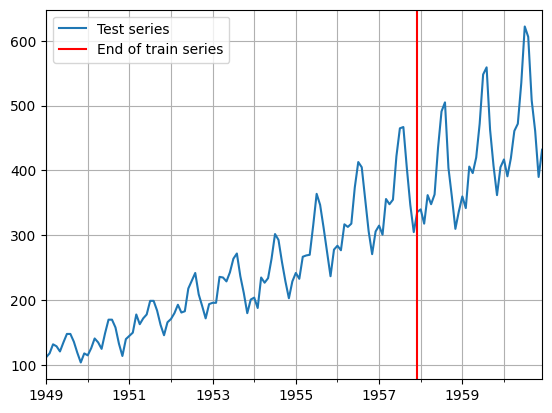

In [12]:
# Preparar los datos de entrenamiento y prueba
steps = 36  # Ventana de predicción de 36 meses
end_train = df_airpassengers.index[-steps - 1]

# Datos de entrenamiento
training_data = ListDataset(
    [{"start": df_airpassengers.index[0], "target": df_airpassengers.Sales[:end_train]}],
    freq="M"
)

# Datos de prueba (train + test)
test_data = ListDataset(
    [{"start": df_airpassengers.index[0], "target": df_airpassengers.Sales}],
    freq="M"
)

# Visualizar la serie temporal y la división de entrenamiento/prueba
test_series = to_pandas(next(iter(test_data)))
test_series.plot()
plt.axvline(end_train, color="r")  # Línea roja para marcar el fin de entrenamiento
plt.grid(which="both")
plt.legend(["Test series", "End of train series"], loc="upper left")
plt.show()

In [13]:
# Configurar el modelo DeepAR
estimator = DeepAREstimator(
    freq="M",
    context_length=24,  # Número de pasos en el contexto
    prediction_length=steps,  # Longitud de predicción
    trainer_kwargs={"max_epochs": 100, "accelerator": "cpu"}
)

# Entrenar el modelo
predictor = estimator.train(training_data)

# Realizar predicciones en el conjunto de prueba
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,
    predictor=predictor,
    num_samples=100  # Número de caminos de muestra para la evaluación
)

c:\Users\tavin\Downloads\Practica 7\myenv\Lib\site-packages\gluonts\time_feature\_base.py:249: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = to_offset(freq_str)
c:\Users\tavin\Downloads\Practica 7\myenv\Lib\site-packages\gluonts\time_feature\lag.py:104: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = to_offset(freq_str)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\tavin\Downloads\Practica 7\myenv\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages ar

Epoch 0: |          | 50/? [00:01<00:00, 35.96it/s, v_num=4, train_loss=5.400]

Epoch 0, global step 50: 'train_loss' reached 5.39540 (best 5.39540), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:01<00:00, 36.59it/s, v_num=4, train_loss=4.540]

Epoch 1, global step 100: 'train_loss' reached 4.54011 (best 4.54011), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:01<00:00, 38.37it/s, v_num=4, train_loss=4.210]

Epoch 2, global step 150: 'train_loss' reached 4.20563 (best 4.20563), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:01<00:00, 38.69it/s, v_num=4, train_loss=4.010]

Epoch 3, global step 200: 'train_loss' reached 4.01348 (best 4.01348), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:01<00:00, 38.59it/s, v_num=4, train_loss=3.950]

Epoch 4, global step 250: 'train_loss' reached 3.95278 (best 3.95278), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:01<00:00, 40.75it/s, v_num=4, train_loss=3.780]

Epoch 5, global step 300: 'train_loss' reached 3.78345 (best 3.78345), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=5-step=300.ckpt' as top 1


Epoch 6: |          | 50/? [00:01<00:00, 40.32it/s, v_num=4, train_loss=3.700]

Epoch 6, global step 350: 'train_loss' reached 3.69505 (best 3.69505), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=6-step=350.ckpt' as top 1


Epoch 7: |          | 50/? [00:01<00:00, 39.28it/s, v_num=4, train_loss=3.750]

Epoch 7, global step 400: 'train_loss' was not in top 1


Epoch 8: |          | 50/? [00:01<00:00, 38.62it/s, v_num=4, train_loss=3.670]

Epoch 8, global step 450: 'train_loss' reached 3.67106 (best 3.67106), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=8-step=450.ckpt' as top 1


Epoch 9: |          | 50/? [00:01<00:00, 37.97it/s, v_num=4, train_loss=3.660]

Epoch 9, global step 500: 'train_loss' reached 3.66362 (best 3.66362), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=9-step=500.ckpt' as top 1


Epoch 10: |          | 50/? [00:01<00:00, 37.84it/s, v_num=4, train_loss=3.590]

Epoch 10, global step 550: 'train_loss' reached 3.58799 (best 3.58799), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=10-step=550.ckpt' as top 1


Epoch 11: |          | 50/? [00:01<00:00, 37.44it/s, v_num=4, train_loss=3.610]

Epoch 11, global step 600: 'train_loss' was not in top 1


Epoch 12: |          | 50/? [00:01<00:00, 36.37it/s, v_num=4, train_loss=3.580]

Epoch 12, global step 650: 'train_loss' reached 3.58141 (best 3.58141), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=12-step=650.ckpt' as top 1


Epoch 13: |          | 50/? [00:01<00:00, 38.57it/s, v_num=4, train_loss=3.530]

Epoch 13, global step 700: 'train_loss' reached 3.53473 (best 3.53473), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=13-step=700.ckpt' as top 1


Epoch 14: |          | 50/? [00:01<00:00, 41.31it/s, v_num=4, train_loss=3.500]

Epoch 14, global step 750: 'train_loss' reached 3.50164 (best 3.50164), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=14-step=750.ckpt' as top 1


Epoch 15: |          | 50/? [00:01<00:00, 40.16it/s, v_num=4, train_loss=3.470]

Epoch 15, global step 800: 'train_loss' reached 3.46983 (best 3.46983), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=15-step=800.ckpt' as top 1


Epoch 16: |          | 50/? [00:01<00:00, 39.66it/s, v_num=4, train_loss=3.460]

Epoch 16, global step 850: 'train_loss' reached 3.45815 (best 3.45815), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=16-step=850.ckpt' as top 1


Epoch 17: |          | 50/? [00:01<00:00, 38.69it/s, v_num=4, train_loss=3.350]

Epoch 17, global step 900: 'train_loss' reached 3.35439 (best 3.35439), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=17-step=900.ckpt' as top 1


Epoch 18: |          | 50/? [00:01<00:00, 38.82it/s, v_num=4, train_loss=3.310]

Epoch 18, global step 950: 'train_loss' reached 3.30702 (best 3.30702), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=18-step=950.ckpt' as top 1


Epoch 19: |          | 50/? [00:01<00:00, 39.82it/s, v_num=4, train_loss=3.250]

Epoch 19, global step 1000: 'train_loss' reached 3.24540 (best 3.24540), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=19-step=1000.ckpt' as top 1


Epoch 20: |          | 50/? [00:01<00:00, 39.12it/s, v_num=4, train_loss=3.220]

Epoch 20, global step 1050: 'train_loss' reached 3.22186 (best 3.22186), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=20-step=1050.ckpt' as top 1


Epoch 21: |          | 50/? [00:01<00:00, 39.24it/s, v_num=4, train_loss=3.210]

Epoch 21, global step 1100: 'train_loss' reached 3.20572 (best 3.20572), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=21-step=1100.ckpt' as top 1


Epoch 22: |          | 50/? [00:01<00:00, 41.28it/s, v_num=4, train_loss=3.200]

Epoch 22, global step 1150: 'train_loss' reached 3.19553 (best 3.19553), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=22-step=1150.ckpt' as top 1


Epoch 23: |          | 50/? [00:01<00:00, 38.75it/s, v_num=4, train_loss=3.170]

Epoch 23, global step 1200: 'train_loss' reached 3.16967 (best 3.16967), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=23-step=1200.ckpt' as top 1


Epoch 24: |          | 50/? [00:01<00:00, 41.38it/s, v_num=4, train_loss=3.130]

Epoch 24, global step 1250: 'train_loss' reached 3.13053 (best 3.13053), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=24-step=1250.ckpt' as top 1


Epoch 25: |          | 50/? [00:01<00:00, 41.05it/s, v_num=4, train_loss=3.150]

Epoch 25, global step 1300: 'train_loss' was not in top 1


Epoch 26: |          | 50/? [00:01<00:00, 40.88it/s, v_num=4, train_loss=3.100]

Epoch 26, global step 1350: 'train_loss' reached 3.10196 (best 3.10196), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=26-step=1350.ckpt' as top 1


Epoch 27: |          | 50/? [00:01<00:00, 39.45it/s, v_num=4, train_loss=3.080]

Epoch 27, global step 1400: 'train_loss' reached 3.08419 (best 3.08419), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=27-step=1400.ckpt' as top 1


Epoch 28: |          | 50/? [00:01<00:00, 40.72it/s, v_num=4, train_loss=3.060]

Epoch 28, global step 1450: 'train_loss' reached 3.06116 (best 3.06116), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=28-step=1450.ckpt' as top 1


Epoch 29: |          | 50/? [00:01<00:00, 40.88it/s, v_num=4, train_loss=3.090]

Epoch 29, global step 1500: 'train_loss' was not in top 1


Epoch 30: |          | 50/? [00:01<00:00, 39.93it/s, v_num=4, train_loss=3.040]

Epoch 30, global step 1550: 'train_loss' reached 3.04088 (best 3.04088), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=30-step=1550.ckpt' as top 1


Epoch 31: |          | 50/? [00:01<00:00, 41.76it/s, v_num=4, train_loss=2.980]

Epoch 31, global step 1600: 'train_loss' reached 2.97549 (best 2.97549), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=31-step=1600.ckpt' as top 1


Epoch 32: |          | 50/? [00:01<00:00, 40.51it/s, v_num=4, train_loss=3.020]

Epoch 32, global step 1650: 'train_loss' was not in top 1


Epoch 33: |          | 50/? [00:01<00:00, 41.19it/s, v_num=4, train_loss=2.990]

Epoch 33, global step 1700: 'train_loss' was not in top 1


Epoch 34: |          | 50/? [00:01<00:00, 39.73it/s, v_num=4, train_loss=2.990]

Epoch 34, global step 1750: 'train_loss' was not in top 1


Epoch 35: |          | 50/? [00:01<00:00, 41.45it/s, v_num=4, train_loss=2.920]

Epoch 35, global step 1800: 'train_loss' reached 2.92375 (best 2.92375), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=35-step=1800.ckpt' as top 1


Epoch 36: |          | 50/? [00:01<00:00, 40.73it/s, v_num=4, train_loss=2.920]

Epoch 36, global step 1850: 'train_loss' reached 2.91980 (best 2.91980), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=36-step=1850.ckpt' as top 1


Epoch 37: |          | 50/? [00:01<00:00, 39.94it/s, v_num=4, train_loss=2.950]

Epoch 37, global step 1900: 'train_loss' was not in top 1


Epoch 38: |          | 50/? [00:01<00:00, 40.28it/s, v_num=4, train_loss=2.910]

Epoch 38, global step 1950: 'train_loss' reached 2.91391 (best 2.91391), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=38-step=1950.ckpt' as top 1


Epoch 39: |          | 50/? [00:01<00:00, 40.36it/s, v_num=4, train_loss=2.870]

Epoch 39, global step 2000: 'train_loss' reached 2.86783 (best 2.86783), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=39-step=2000.ckpt' as top 1


Epoch 40: |          | 50/? [00:01<00:00, 41.18it/s, v_num=4, train_loss=2.870]

Epoch 40, global step 2050: 'train_loss' was not in top 1


Epoch 41: |          | 50/? [00:01<00:00, 40.41it/s, v_num=4, train_loss=2.830]

Epoch 41, global step 2100: 'train_loss' reached 2.82886 (best 2.82886), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=41-step=2100.ckpt' as top 1


Epoch 42: |          | 50/? [00:01<00:00, 40.82it/s, v_num=4, train_loss=2.820]

Epoch 42, global step 2150: 'train_loss' reached 2.82253 (best 2.82253), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=42-step=2150.ckpt' as top 1


Epoch 43: |          | 50/? [00:01<00:00, 41.62it/s, v_num=4, train_loss=2.830]

Epoch 43, global step 2200: 'train_loss' was not in top 1


Epoch 44: |          | 50/? [00:01<00:00, 40.48it/s, v_num=4, train_loss=2.830]

Epoch 44, global step 2250: 'train_loss' was not in top 1


Epoch 45: |          | 50/? [00:01<00:00, 40.31it/s, v_num=4, train_loss=2.820]

Epoch 45, global step 2300: 'train_loss' reached 2.81559 (best 2.81559), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=45-step=2300.ckpt' as top 1


Epoch 46: |          | 50/? [00:01<00:00, 40.77it/s, v_num=4, train_loss=2.790]

Epoch 46, global step 2350: 'train_loss' reached 2.78539 (best 2.78539), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=46-step=2350.ckpt' as top 1


Epoch 47: |          | 50/? [00:01<00:00, 41.15it/s, v_num=4, train_loss=2.790]

Epoch 47, global step 2400: 'train_loss' was not in top 1


Epoch 48: |          | 50/? [00:01<00:00, 40.06it/s, v_num=4, train_loss=2.780]

Epoch 48, global step 2450: 'train_loss' reached 2.78303 (best 2.78303), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=48-step=2450.ckpt' as top 1


Epoch 49: |          | 50/? [00:01<00:00, 41.69it/s, v_num=4, train_loss=2.760]

Epoch 49, global step 2500: 'train_loss' reached 2.75574 (best 2.75574), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=49-step=2500.ckpt' as top 1


Epoch 50: |          | 50/? [00:01<00:00, 41.18it/s, v_num=4, train_loss=2.760]

Epoch 50, global step 2550: 'train_loss' was not in top 1


Epoch 51: |          | 50/? [00:01<00:00, 40.67it/s, v_num=4, train_loss=2.750]

Epoch 51, global step 2600: 'train_loss' reached 2.74588 (best 2.74588), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=51-step=2600.ckpt' as top 1


Epoch 52: |          | 50/? [00:01<00:00, 39.94it/s, v_num=4, train_loss=2.730]

Epoch 52, global step 2650: 'train_loss' reached 2.72853 (best 2.72853), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=52-step=2650.ckpt' as top 1


Epoch 53: |          | 50/? [00:01<00:00, 41.09it/s, v_num=4, train_loss=2.710]

Epoch 53, global step 2700: 'train_loss' reached 2.70978 (best 2.70978), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=53-step=2700.ckpt' as top 1


Epoch 54: |          | 50/? [00:01<00:00, 40.75it/s, v_num=4, train_loss=2.710]

Epoch 54, global step 2750: 'train_loss' reached 2.70578 (best 2.70578), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=54-step=2750.ckpt' as top 1


Epoch 55: |          | 50/? [00:01<00:00, 39.92it/s, v_num=4, train_loss=2.700]

Epoch 55, global step 2800: 'train_loss' reached 2.69718 (best 2.69718), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=55-step=2800.ckpt' as top 1


Epoch 56: |          | 50/? [00:01<00:00, 40.23it/s, v_num=4, train_loss=2.690]

Epoch 56, global step 2850: 'train_loss' reached 2.69017 (best 2.69017), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=56-step=2850.ckpt' as top 1


Epoch 57: |          | 50/? [00:01<00:00, 40.77it/s, v_num=4, train_loss=2.680]

Epoch 57, global step 2900: 'train_loss' reached 2.67737 (best 2.67737), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=57-step=2900.ckpt' as top 1


Epoch 58: |          | 50/? [00:01<00:00, 40.38it/s, v_num=4, train_loss=2.650]

Epoch 58, global step 2950: 'train_loss' reached 2.64939 (best 2.64939), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=58-step=2950.ckpt' as top 1


Epoch 59: |          | 50/? [00:01<00:00, 39.22it/s, v_num=4, train_loss=2.660]

Epoch 59, global step 3000: 'train_loss' was not in top 1


Epoch 60: |          | 50/? [00:01<00:00, 41.34it/s, v_num=4, train_loss=2.630]

Epoch 60, global step 3050: 'train_loss' reached 2.63320 (best 2.63320), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=60-step=3050.ckpt' as top 1


Epoch 61: |          | 50/? [00:01<00:00, 40.76it/s, v_num=4, train_loss=2.640]

Epoch 61, global step 3100: 'train_loss' was not in top 1


Epoch 62: |          | 50/? [00:01<00:00, 40.52it/s, v_num=4, train_loss=2.650]

Epoch 62, global step 3150: 'train_loss' was not in top 1


Epoch 63: |          | 50/? [00:01<00:00, 41.12it/s, v_num=4, train_loss=2.620]

Epoch 63, global step 3200: 'train_loss' reached 2.62393 (best 2.62393), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=63-step=3200.ckpt' as top 1


Epoch 64: |          | 50/? [00:01<00:00, 41.36it/s, v_num=4, train_loss=2.610]

Epoch 64, global step 3250: 'train_loss' reached 2.61299 (best 2.61299), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=64-step=3250.ckpt' as top 1


Epoch 65: |          | 50/? [00:01<00:00, 40.01it/s, v_num=4, train_loss=2.600]

Epoch 65, global step 3300: 'train_loss' reached 2.59887 (best 2.59887), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=65-step=3300.ckpt' as top 1


Epoch 66: |          | 50/? [00:01<00:00, 40.10it/s, v_num=4, train_loss=2.730]

Epoch 66, global step 3350: 'train_loss' was not in top 1


Epoch 67: |          | 50/? [00:01<00:00, 36.47it/s, v_num=4, train_loss=2.620]

Epoch 67, global step 3400: 'train_loss' was not in top 1


Epoch 68: |          | 50/? [00:01<00:00, 35.33it/s, v_num=4, train_loss=2.590]

Epoch 68, global step 3450: 'train_loss' reached 2.58838 (best 2.58838), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=68-step=3450.ckpt' as top 1


Epoch 69: |          | 50/? [00:01<00:00, 39.21it/s, v_num=4, train_loss=2.550]

Epoch 69, global step 3500: 'train_loss' reached 2.54563 (best 2.54563), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=69-step=3500.ckpt' as top 1


Epoch 70: |          | 50/? [00:01<00:00, 38.83it/s, v_num=4, train_loss=2.560]

Epoch 70, global step 3550: 'train_loss' was not in top 1


Epoch 71: |          | 50/? [00:01<00:00, 40.27it/s, v_num=4, train_loss=2.550]

Epoch 71, global step 3600: 'train_loss' was not in top 1


Epoch 72: |          | 50/? [00:01<00:00, 39.17it/s, v_num=4, train_loss=2.550]

Epoch 72, global step 3650: 'train_loss' was not in top 1


Epoch 73: |          | 50/? [00:01<00:00, 40.24it/s, v_num=4, train_loss=2.550]

Epoch 73, global step 3700: 'train_loss' was not in top 1


Epoch 74: |          | 50/? [00:01<00:00, 38.71it/s, v_num=4, train_loss=2.540]

Epoch 74, global step 3750: 'train_loss' reached 2.53655 (best 2.53655), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=74-step=3750.ckpt' as top 1


Epoch 75: |          | 50/? [00:01<00:00, 39.40it/s, v_num=4, train_loss=2.530]

Epoch 75, global step 3800: 'train_loss' reached 2.52975 (best 2.52975), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=75-step=3800.ckpt' as top 1


Epoch 76: |          | 50/? [00:01<00:00, 38.54it/s, v_num=4, train_loss=2.550]

Epoch 76, global step 3850: 'train_loss' was not in top 1


Epoch 77: |          | 50/? [00:01<00:00, 37.80it/s, v_num=4, train_loss=2.520]

Epoch 77, global step 3900: 'train_loss' reached 2.51614 (best 2.51614), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=77-step=3900.ckpt' as top 1


Epoch 78: |          | 50/? [00:01<00:00, 39.28it/s, v_num=4, train_loss=2.520]

Epoch 78, global step 3950: 'train_loss' was not in top 1


Epoch 79: |          | 50/? [00:01<00:00, 38.90it/s, v_num=4, train_loss=2.500]

Epoch 79, global step 4000: 'train_loss' reached 2.49893 (best 2.49893), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=79-step=4000.ckpt' as top 1


Epoch 80: |          | 50/? [00:01<00:00, 37.42it/s, v_num=4, train_loss=2.490]

Epoch 80, global step 4050: 'train_loss' reached 2.49062 (best 2.49062), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=80-step=4050.ckpt' as top 1


Epoch 81: |          | 50/? [00:01<00:00, 38.60it/s, v_num=4, train_loss=2.490]

Epoch 81, global step 4100: 'train_loss' reached 2.48627 (best 2.48627), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=81-step=4100.ckpt' as top 1


Epoch 82: |          | 50/? [00:01<00:00, 36.81it/s, v_num=4, train_loss=2.490]

Epoch 82, global step 4150: 'train_loss' was not in top 1


Epoch 83: |          | 50/? [00:01<00:00, 39.95it/s, v_num=4, train_loss=2.480]

Epoch 83, global step 4200: 'train_loss' reached 2.48444 (best 2.48444), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=83-step=4200.ckpt' as top 1


Epoch 84: |          | 50/? [00:01<00:00, 38.37it/s, v_num=4, train_loss=2.470]

Epoch 84, global step 4250: 'train_loss' reached 2.46960 (best 2.46960), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=84-step=4250.ckpt' as top 1


Epoch 85: |          | 50/? [00:01<00:00, 38.53it/s, v_num=4, train_loss=2.500]

Epoch 85, global step 4300: 'train_loss' was not in top 1


Epoch 86: |          | 50/? [00:01<00:00, 39.37it/s, v_num=4, train_loss=2.540]

Epoch 86, global step 4350: 'train_loss' was not in top 1


Epoch 87: |          | 50/? [00:01<00:00, 38.61it/s, v_num=4, train_loss=2.550]

Epoch 87, global step 4400: 'train_loss' was not in top 1


Epoch 88: |          | 50/? [00:01<00:00, 37.18it/s, v_num=4, train_loss=2.510]

Epoch 88, global step 4450: 'train_loss' was not in top 1


Epoch 89: |          | 50/? [00:01<00:00, 38.09it/s, v_num=4, train_loss=2.420]

Epoch 89, global step 4500: 'train_loss' reached 2.41980 (best 2.41980), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=89-step=4500.ckpt' as top 1


Epoch 90: |          | 50/? [00:01<00:00, 37.25it/s, v_num=4, train_loss=2.440]

Epoch 90, global step 4550: 'train_loss' was not in top 1


Epoch 91: |          | 50/? [00:01<00:00, 39.39it/s, v_num=4, train_loss=2.440]

Epoch 91, global step 4600: 'train_loss' was not in top 1


Epoch 92: |          | 50/? [00:01<00:00, 39.61it/s, v_num=4, train_loss=2.400]

Epoch 92, global step 4650: 'train_loss' reached 2.39961 (best 2.39961), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=92-step=4650.ckpt' as top 1


Epoch 93: |          | 50/? [00:01<00:00, 38.33it/s, v_num=4, train_loss=2.420]

Epoch 93, global step 4700: 'train_loss' was not in top 1


Epoch 94: |          | 50/? [00:01<00:00, 38.34it/s, v_num=4, train_loss=2.400]

Epoch 94, global step 4750: 'train_loss' reached 2.39739 (best 2.39739), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=94-step=4750.ckpt' as top 1


Epoch 95: |          | 50/? [00:01<00:00, 38.21it/s, v_num=4, train_loss=2.400]

Epoch 95, global step 4800: 'train_loss' was not in top 1


Epoch 96: |          | 50/? [00:01<00:00, 37.29it/s, v_num=4, train_loss=2.400]

Epoch 96, global step 4850: 'train_loss' was not in top 1


Epoch 97: |          | 50/? [00:01<00:00, 38.24it/s, v_num=4, train_loss=2.400]

Epoch 97, global step 4900: 'train_loss' was not in top 1


Epoch 98: |          | 50/? [00:01<00:00, 36.92it/s, v_num=4, train_loss=2.380]

Epoch 98, global step 4950: 'train_loss' reached 2.37552 (best 2.37552), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_4\\checkpoints\\epoch=98-step=4950.ckpt' as top 1


Epoch 99: |          | 50/? [00:01<00:00, 38.86it/s, v_num=4, train_loss=2.390]

Epoch 99, global step 5000: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: |          | 50/? [00:01<00:00, 38.56it/s, v_num=4, train_loss=2.390]


c:\Users\tavin\Downloads\Practica 7\myenv\Lib\site-packages\gluonts\time_feature\lag.py:104: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = to_offset(freq_str)


Number of sample paths: 100
Dimension of samples: (100, 36)
Start date of the forecast window: 1958-01
Frequency of the time series: <MonthEnd>


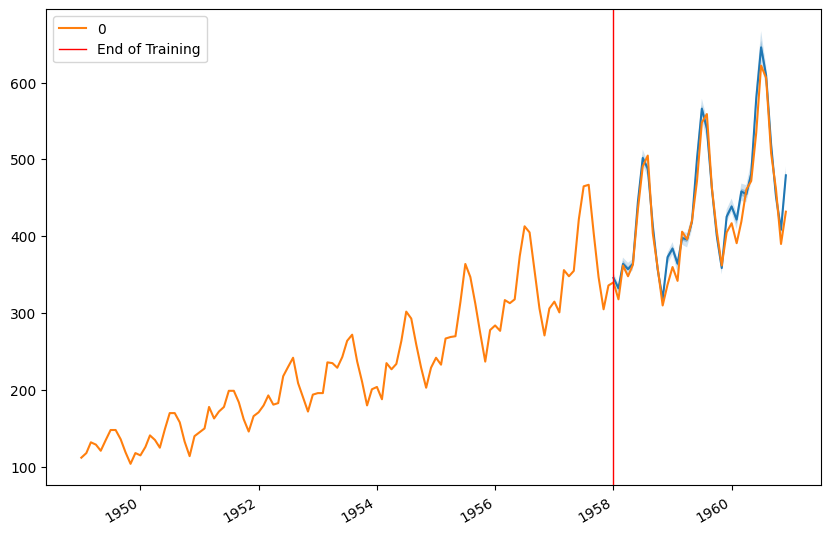

Error cuadrático medio DEEPAR: 12626.52
Raíz cuadrada de ECM DEEPAR: 112.37
Error porcentual medio DEEPAR: 21.25%


In [14]:
# Convertir las predicciones en listas
forecasts = list(forecast_it)
tss = list(ts_it)

# Detalles de la predicción
forecast_entry = forecasts[0]
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

# Graficar predicciones
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
forecast_entry.plot(ax=ax)
tss[0].plot(ax=ax)
plt.axvline(end_train, lw=1, color="r", label="End of Training")
plt.legend()
plt.show()

# Calcular el error
y_truth = df_airpassengers.loc[end_train:]
predicciones_deepar = forecast_entry.mean_ts[end_train:]
mse = ((predicciones_deepar.values - y_truth.values) ** 2).mean()
rele = (np.abs(predicciones_deepar.values - y_truth.values) / y_truth.values * 100).mean()

print(f"Error cuadrático medio DEEPAR: {round(mse, 2)}")
print(f"Raíz cuadrada de ECM DEEPAR: {round(np.sqrt(mse), 2)}")
print(f"Error porcentual medio DEEPAR: {round(rele, 2)}%")

5. Comparar entre sí las predicciones a largo plazo (años 1960 a 1970) de ARIMA, Holt
Winters y Prophet 

02:53:17 - cmdstanpy - INFO - Chain [1] start processing
02:53:17 - cmdstanpy - INFO - Chain [1] done processing


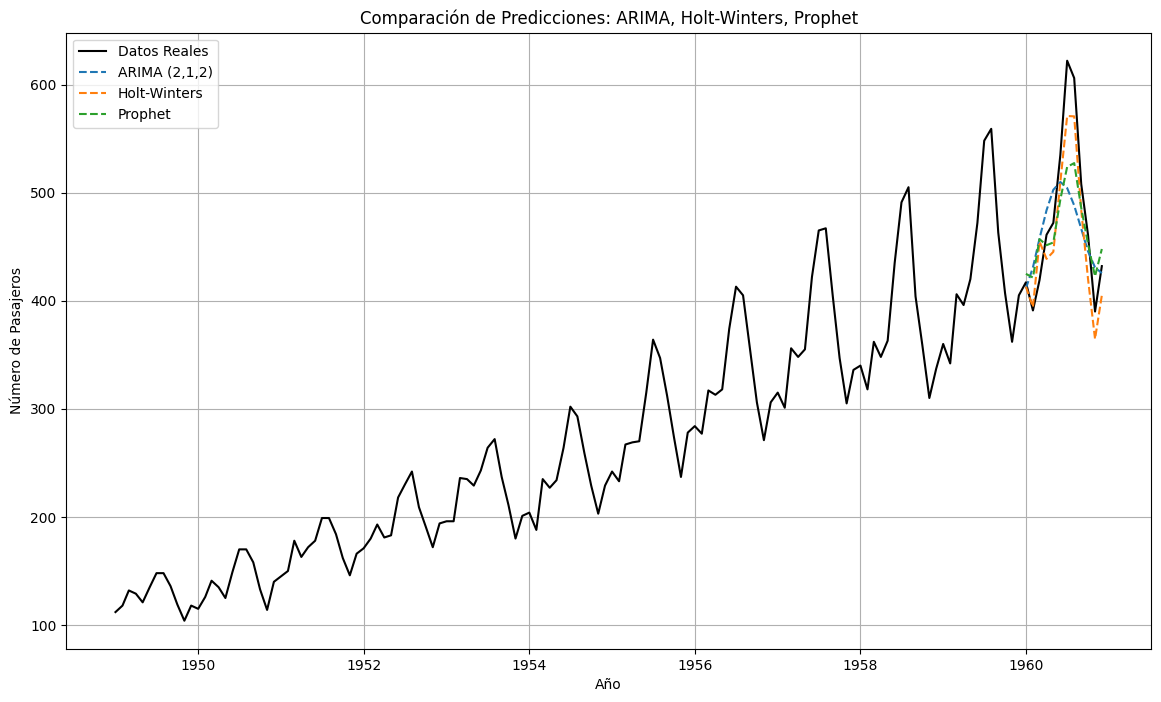

RMSE ARIMA: 55.22
RMSE Holt-Winters: 29.74
RMSE Prophet: 43.07


In [15]:
# Librerías necesarias
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", message="No frequency information was provided")

# Cargar datos
data = pd.read_csv("AirPassengers.csv", parse_dates=["Month"])
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)
data['#Passengers'] = data['#Passengers'].astype(float)

# Dividir en entrenamiento (1949-1960) y validación (1960-1970)
train_data = data[data.index < "1960"]
test_data = data[data.index >= "1960"]

# 1. Modelo ARIMA
arima_model = ARIMA(train_data['#Passengers'], order=(2, 1, 2))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=len(test_data))

# 2. Modelo Holt-Winters
hw_model = ExponentialSmoothing(
    train_data['#Passengers'],
    seasonal='multiplicative',
    seasonal_periods=12
).fit()
hw_forecast = hw_model.forecast(len(test_data))

# 3. Modelo Prophet
prophet_data = train_data.reset_index().rename(columns={"Month": "ds", "#Passengers": "y"})
prophet_model = Prophet(yearly_seasonality=True)
prophet_model.fit(prophet_data)
future = prophet_model.make_future_dataframe(periods=len(test_data), freq='MS')
prophet_forecast = prophet_model.predict(future)
prophet_forecast = prophet_forecast[prophet_forecast['ds'] >= "1960"]['yhat']

# Comparación de predicciones
plt.figure(figsize=(14, 8))
plt.plot(data.index, data['#Passengers'], label="Datos Reales", color="black")
plt.plot(test_data.index, arima_forecast, label="ARIMA (2,1,2)", linestyle='--')
plt.plot(test_data.index, hw_forecast, label="Holt-Winters", linestyle='--')
plt.plot(test_data.index, prophet_forecast.values, label="Prophet", linestyle='--')
plt.title("Comparación de Predicciones: ARIMA, Holt-Winters, Prophet")
plt.xlabel("Año")
plt.ylabel("Número de Pasajeros")
plt.legend()
plt.grid()
plt.show()

# Métricas de evaluación (RMSE)
from sklearn.metrics import mean_squared_error
arima_rmse = np.sqrt(mean_squared_error(test_data['#Passengers'], arima_forecast))
hw_rmse = np.sqrt(mean_squared_error(test_data['#Passengers'], hw_forecast))
prophet_rmse = np.sqrt(mean_squared_error(test_data['#Passengers'], prophet_forecast))

print(f"RMSE ARIMA: {arima_rmse:.2f}")
print(f"RMSE Holt-Winters: {hw_rmse:.2f}")
print(f"RMSE Prophet: {prophet_rmse:.2f}")


6. (Opcional, fácil) Incluir las predicciones a largo plazo de DeepAR en la comparativa
anterior

02:56:25 - cmdstanpy - INFO - Chain [1] start processing
02:56:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\tavin\Downloads\Practica 7\myenv\Lib\site-packages\gluonts\dataset\common.py:255: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ProcessDataEntry(to_offset(freq), one_dim_target, use_timestamp),
c:\Users\tavin\Downloads\Practica 7\myenv\Lib\site-packages\gluonts\time_feature\_base.py:249: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = to_offset(freq_str)
c:\Users\tavin\Downloads\Practica 7\myenv\Lib\site-packages\gluonts\time_feature\lag.py:104: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = to_offset(freq_str)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\tavin\Downloads\Practica 7\myenv\Lib\site-packages\lightning\

Epoch 0: |          | 50/? [00:01<00:00, 46.51it/s, v_num=5, train_loss=5.810]

Epoch 0, global step 50: 'train_loss' reached 5.80787 (best 5.80787), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:01<00:00, 48.86it/s, v_num=5, train_loss=4.920]

Epoch 1, global step 100: 'train_loss' reached 4.92056 (best 4.92056), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:01<00:00, 47.78it/s, v_num=5, train_loss=4.600]

Epoch 2, global step 150: 'train_loss' reached 4.59870 (best 4.59870), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:01<00:00, 49.97it/s, v_num=5, train_loss=4.490]

Epoch 3, global step 200: 'train_loss' reached 4.48667 (best 4.48667), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:01<00:00, 48.07it/s, v_num=5, train_loss=4.310]

Epoch 4, global step 250: 'train_loss' reached 4.31061 (best 4.31061), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:01<00:00, 48.00it/s, v_num=5, train_loss=4.260]

Epoch 5, global step 300: 'train_loss' reached 4.26345 (best 4.26345), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=5-step=300.ckpt' as top 1


Epoch 6: |          | 50/? [00:01<00:00, 48.42it/s, v_num=5, train_loss=4.130]

Epoch 6, global step 350: 'train_loss' reached 4.13416 (best 4.13416), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=6-step=350.ckpt' as top 1


Epoch 7: |          | 50/? [00:01<00:00, 45.85it/s, v_num=5, train_loss=4.100]

Epoch 7, global step 400: 'train_loss' reached 4.09529 (best 4.09529), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=7-step=400.ckpt' as top 1


Epoch 8: |          | 50/? [00:01<00:00, 44.82it/s, v_num=5, train_loss=4.080]

Epoch 8, global step 450: 'train_loss' reached 4.08240 (best 4.08240), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=8-step=450.ckpt' as top 1


Epoch 9: |          | 50/? [00:01<00:00, 48.92it/s, v_num=5, train_loss=3.930]

Epoch 9, global step 500: 'train_loss' reached 3.92571 (best 3.92571), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=9-step=500.ckpt' as top 1


Epoch 10: |          | 50/? [00:00<00:00, 53.23it/s, v_num=5, train_loss=3.910]

Epoch 10, global step 550: 'train_loss' reached 3.91369 (best 3.91369), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=10-step=550.ckpt' as top 1


Epoch 11: |          | 50/? [00:00<00:00, 52.84it/s, v_num=5, train_loss=3.900]

Epoch 11, global step 600: 'train_loss' reached 3.90455 (best 3.90455), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=11-step=600.ckpt' as top 1


Epoch 12: |          | 50/? [00:01<00:00, 49.54it/s, v_num=5, train_loss=3.870]

Epoch 12, global step 650: 'train_loss' reached 3.87115 (best 3.87115), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=12-step=650.ckpt' as top 1


Epoch 13: |          | 50/? [00:01<00:00, 49.66it/s, v_num=5, train_loss=3.790]

Epoch 13, global step 700: 'train_loss' reached 3.79347 (best 3.79347), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=13-step=700.ckpt' as top 1


Epoch 14: |          | 50/? [00:00<00:00, 50.43it/s, v_num=5, train_loss=3.770]

Epoch 14, global step 750: 'train_loss' reached 3.76544 (best 3.76544), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=14-step=750.ckpt' as top 1


Epoch 15: |          | 50/? [00:00<00:00, 50.91it/s, v_num=5, train_loss=3.750]

Epoch 15, global step 800: 'train_loss' reached 3.75264 (best 3.75264), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=15-step=800.ckpt' as top 1


Epoch 16: |          | 50/? [00:00<00:00, 50.02it/s, v_num=5, train_loss=3.760]

Epoch 16, global step 850: 'train_loss' was not in top 1


Epoch 17: |          | 50/? [00:01<00:00, 46.17it/s, v_num=5, train_loss=3.790]

Epoch 17, global step 900: 'train_loss' was not in top 1


Epoch 18: |          | 50/? [00:01<00:00, 46.50it/s, v_num=5, train_loss=3.700]

Epoch 18, global step 950: 'train_loss' reached 3.70119 (best 3.70119), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=18-step=950.ckpt' as top 1


Epoch 19: |          | 50/? [00:00<00:00, 52.80it/s, v_num=5, train_loss=3.710]

Epoch 19, global step 1000: 'train_loss' was not in top 1


Epoch 20: |          | 50/? [00:00<00:00, 50.61it/s, v_num=5, train_loss=3.710]

Epoch 20, global step 1050: 'train_loss' was not in top 1


Epoch 21: |          | 50/? [00:01<00:00, 49.24it/s, v_num=5, train_loss=3.730]

Epoch 21, global step 1100: 'train_loss' was not in top 1


Epoch 22: |          | 50/? [00:00<00:00, 52.47it/s, v_num=5, train_loss=3.720]

Epoch 22, global step 1150: 'train_loss' was not in top 1


Epoch 23: |          | 50/? [00:01<00:00, 49.64it/s, v_num=5, train_loss=3.710]

Epoch 23, global step 1200: 'train_loss' was not in top 1


Epoch 24: |          | 50/? [00:01<00:00, 45.74it/s, v_num=5, train_loss=3.580]

Epoch 24, global step 1250: 'train_loss' reached 3.58107 (best 3.58107), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=24-step=1250.ckpt' as top 1


Epoch 25: |          | 50/? [00:01<00:00, 49.55it/s, v_num=5, train_loss=3.580]

Epoch 25, global step 1300: 'train_loss' was not in top 1


Epoch 26: |          | 50/? [00:01<00:00, 48.38it/s, v_num=5, train_loss=3.590]

Epoch 26, global step 1350: 'train_loss' was not in top 1


Epoch 27: |          | 50/? [00:01<00:00, 46.22it/s, v_num=5, train_loss=3.570]

Epoch 27, global step 1400: 'train_loss' reached 3.56965 (best 3.56965), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=27-step=1400.ckpt' as top 1


Epoch 28: |          | 50/? [00:00<00:00, 50.61it/s, v_num=5, train_loss=3.540]

Epoch 28, global step 1450: 'train_loss' reached 3.54377 (best 3.54377), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=28-step=1450.ckpt' as top 1


Epoch 29: |          | 50/? [00:01<00:00, 49.70it/s, v_num=5, train_loss=3.550]

Epoch 29, global step 1500: 'train_loss' was not in top 1


Epoch 30: |          | 50/? [00:01<00:00, 46.95it/s, v_num=5, train_loss=3.530]

Epoch 30, global step 1550: 'train_loss' reached 3.52598 (best 3.52598), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=30-step=1550.ckpt' as top 1


Epoch 31: |          | 50/? [00:01<00:00, 48.40it/s, v_num=5, train_loss=3.510]

Epoch 31, global step 1600: 'train_loss' reached 3.50977 (best 3.50977), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=31-step=1600.ckpt' as top 1


Epoch 32: |          | 50/? [00:01<00:00, 48.31it/s, v_num=5, train_loss=3.490]

Epoch 32, global step 1650: 'train_loss' reached 3.48626 (best 3.48626), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=32-step=1650.ckpt' as top 1


Epoch 33: |          | 50/? [00:01<00:00, 42.53it/s, v_num=5, train_loss=3.510]

Epoch 33, global step 1700: 'train_loss' was not in top 1


Epoch 34: |          | 50/? [00:01<00:00, 48.14it/s, v_num=5, train_loss=3.470]

Epoch 34, global step 1750: 'train_loss' reached 3.47221 (best 3.47221), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=34-step=1750.ckpt' as top 1


Epoch 35: |          | 50/? [00:01<00:00, 48.11it/s, v_num=5, train_loss=3.450]

Epoch 35, global step 1800: 'train_loss' reached 3.44782 (best 3.44782), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=35-step=1800.ckpt' as top 1


Epoch 36: |          | 50/? [00:01<00:00, 49.43it/s, v_num=5, train_loss=3.460]

Epoch 36, global step 1850: 'train_loss' was not in top 1


Epoch 37: |          | 50/? [00:01<00:00, 47.43it/s, v_num=5, train_loss=3.450]

Epoch 37, global step 1900: 'train_loss' was not in top 1


Epoch 38: |          | 50/? [00:01<00:00, 48.88it/s, v_num=5, train_loss=3.440]

Epoch 38, global step 1950: 'train_loss' reached 3.44273 (best 3.44273), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=38-step=1950.ckpt' as top 1


Epoch 39: |          | 50/? [00:01<00:00, 48.61it/s, v_num=5, train_loss=3.380]

Epoch 39, global step 2000: 'train_loss' reached 3.37692 (best 3.37692), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=39-step=2000.ckpt' as top 1


Epoch 40: |          | 50/? [00:01<00:00, 48.03it/s, v_num=5, train_loss=3.370]

Epoch 40, global step 2050: 'train_loss' reached 3.36771 (best 3.36771), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=40-step=2050.ckpt' as top 1


Epoch 41: |          | 50/? [00:01<00:00, 49.39it/s, v_num=5, train_loss=3.390]

Epoch 41, global step 2100: 'train_loss' was not in top 1


Epoch 42: |          | 50/? [00:01<00:00, 43.35it/s, v_num=5, train_loss=3.370]

Epoch 42, global step 2150: 'train_loss' reached 3.36560 (best 3.36560), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=42-step=2150.ckpt' as top 1


Epoch 43: |          | 50/? [00:01<00:00, 44.83it/s, v_num=5, train_loss=3.360]

Epoch 43, global step 2200: 'train_loss' reached 3.36269 (best 3.36269), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=43-step=2200.ckpt' as top 1


Epoch 44: |          | 50/? [00:00<00:00, 50.15it/s, v_num=5, train_loss=3.370]

Epoch 44, global step 2250: 'train_loss' was not in top 1


Epoch 45: |          | 50/? [00:01<00:00, 49.28it/s, v_num=5, train_loss=3.350]

Epoch 45, global step 2300: 'train_loss' reached 3.35133 (best 3.35133), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=45-step=2300.ckpt' as top 1


Epoch 46: |          | 50/? [00:01<00:00, 48.07it/s, v_num=5, train_loss=3.330]

Epoch 46, global step 2350: 'train_loss' reached 3.32772 (best 3.32772), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=46-step=2350.ckpt' as top 1


Epoch 47: |          | 50/? [00:01<00:00, 49.25it/s, v_num=5, train_loss=3.320]

Epoch 47, global step 2400: 'train_loss' reached 3.31745 (best 3.31745), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=47-step=2400.ckpt' as top 1


Epoch 48: |          | 50/? [00:01<00:00, 48.17it/s, v_num=5, train_loss=3.330]

Epoch 48, global step 2450: 'train_loss' was not in top 1


Epoch 49: |          | 50/? [00:00<00:00, 52.17it/s, v_num=5, train_loss=3.340]

Epoch 49, global step 2500: 'train_loss' was not in top 1


Epoch 50: |          | 50/? [00:00<00:00, 53.47it/s, v_num=5, train_loss=3.280]

Epoch 50, global step 2550: 'train_loss' reached 3.28276 (best 3.28276), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=50-step=2550.ckpt' as top 1


Epoch 51: |          | 50/? [00:00<00:00, 52.29it/s, v_num=5, train_loss=3.310]

Epoch 51, global step 2600: 'train_loss' was not in top 1


Epoch 52: |          | 50/? [00:00<00:00, 51.70it/s, v_num=5, train_loss=3.270]

Epoch 52, global step 2650: 'train_loss' reached 3.27289 (best 3.27289), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=52-step=2650.ckpt' as top 1


Epoch 53: |          | 50/? [00:01<00:00, 48.85it/s, v_num=5, train_loss=3.270]

Epoch 53, global step 2700: 'train_loss' was not in top 1


Epoch 54: |          | 50/? [00:01<00:00, 48.72it/s, v_num=5, train_loss=3.260]

Epoch 54, global step 2750: 'train_loss' reached 3.25806 (best 3.25806), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=54-step=2750.ckpt' as top 1


Epoch 55: |          | 50/? [00:01<00:00, 47.12it/s, v_num=5, train_loss=3.250]

Epoch 55, global step 2800: 'train_loss' reached 3.25496 (best 3.25496), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=55-step=2800.ckpt' as top 1


Epoch 56: |          | 50/? [00:01<00:00, 47.42it/s, v_num=5, train_loss=3.250]

Epoch 56, global step 2850: 'train_loss' reached 3.24925 (best 3.24925), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=56-step=2850.ckpt' as top 1


Epoch 57: |          | 50/? [00:00<00:00, 50.74it/s, v_num=5, train_loss=3.250]

Epoch 57, global step 2900: 'train_loss' was not in top 1


Epoch 58: |          | 50/? [00:01<00:00, 49.09it/s, v_num=5, train_loss=3.200]

Epoch 58, global step 2950: 'train_loss' reached 3.20037 (best 3.20037), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=58-step=2950.ckpt' as top 1


Epoch 59: |          | 50/? [00:01<00:00, 49.41it/s, v_num=5, train_loss=3.230]

Epoch 59, global step 3000: 'train_loss' was not in top 1


Epoch 60: |          | 50/? [00:01<00:00, 48.95it/s, v_num=5, train_loss=3.240]

Epoch 60, global step 3050: 'train_loss' was not in top 1


Epoch 61: |          | 50/? [00:01<00:00, 46.08it/s, v_num=5, train_loss=3.210]

Epoch 61, global step 3100: 'train_loss' was not in top 1


Epoch 62: |          | 50/? [00:01<00:00, 42.63it/s, v_num=5, train_loss=3.180]

Epoch 62, global step 3150: 'train_loss' reached 3.17993 (best 3.17993), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=62-step=3150.ckpt' as top 1


Epoch 63: |          | 50/? [00:01<00:00, 47.82it/s, v_num=5, train_loss=3.190]

Epoch 63, global step 3200: 'train_loss' was not in top 1


Epoch 64: |          | 50/? [00:01<00:00, 48.76it/s, v_num=5, train_loss=3.160]

Epoch 64, global step 3250: 'train_loss' reached 3.16275 (best 3.16275), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=64-step=3250.ckpt' as top 1


Epoch 65: |          | 50/? [00:00<00:00, 50.34it/s, v_num=5, train_loss=3.160]

Epoch 65, global step 3300: 'train_loss' reached 3.15529 (best 3.15529), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=65-step=3300.ckpt' as top 1


Epoch 66: |          | 50/? [00:00<00:00, 51.80it/s, v_num=5, train_loss=3.220]

Epoch 66, global step 3350: 'train_loss' was not in top 1


Epoch 67: |          | 50/? [00:00<00:00, 51.72it/s, v_num=5, train_loss=3.250]

Epoch 67, global step 3400: 'train_loss' was not in top 1


Epoch 68: |          | 50/? [00:00<00:00, 50.29it/s, v_num=5, train_loss=3.170]

Epoch 68, global step 3450: 'train_loss' was not in top 1


Epoch 69: |          | 50/? [00:00<00:00, 51.68it/s, v_num=5, train_loss=3.170]

Epoch 69, global step 3500: 'train_loss' was not in top 1


Epoch 70: |          | 50/? [00:00<00:00, 50.90it/s, v_num=5, train_loss=3.160]

Epoch 70, global step 3550: 'train_loss' was not in top 1


Epoch 71: |          | 50/? [00:01<00:00, 49.36it/s, v_num=5, train_loss=3.140]

Epoch 71, global step 3600: 'train_loss' reached 3.13788 (best 3.13788), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=71-step=3600.ckpt' as top 1


Epoch 72: |          | 50/? [00:00<00:00, 50.91it/s, v_num=5, train_loss=3.130]

Epoch 72, global step 3650: 'train_loss' reached 3.13496 (best 3.13496), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=72-step=3650.ckpt' as top 1


Epoch 73: |          | 50/? [00:00<00:00, 51.68it/s, v_num=5, train_loss=3.160]

Epoch 73, global step 3700: 'train_loss' was not in top 1


Epoch 74: |          | 50/? [00:01<00:00, 45.46it/s, v_num=5, train_loss=3.130]

Epoch 74, global step 3750: 'train_loss' reached 3.13291 (best 3.13291), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=74-step=3750.ckpt' as top 1


Epoch 75: |          | 50/? [00:00<00:00, 50.40it/s, v_num=5, train_loss=3.080]

Epoch 75, global step 3800: 'train_loss' reached 3.08454 (best 3.08454), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=75-step=3800.ckpt' as top 1


Epoch 76: |          | 50/? [00:01<00:00, 49.63it/s, v_num=5, train_loss=3.070]

Epoch 76, global step 3850: 'train_loss' reached 3.06673 (best 3.06673), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=76-step=3850.ckpt' as top 1


Epoch 77: |          | 50/? [00:01<00:00, 47.84it/s, v_num=5, train_loss=3.120]

Epoch 77, global step 3900: 'train_loss' was not in top 1


Epoch 78: |          | 50/? [00:01<00:00, 49.63it/s, v_num=5, train_loss=3.100]

Epoch 78, global step 3950: 'train_loss' was not in top 1


Epoch 79: |          | 50/? [00:01<00:00, 49.78it/s, v_num=5, train_loss=3.150]

Epoch 79, global step 4000: 'train_loss' was not in top 1


Epoch 80: |          | 50/? [00:00<00:00, 50.10it/s, v_num=5, train_loss=3.110]

Epoch 80, global step 4050: 'train_loss' was not in top 1


Epoch 81: |          | 50/? [00:01<00:00, 46.98it/s, v_num=5, train_loss=3.120]

Epoch 81, global step 4100: 'train_loss' was not in top 1


Epoch 82: |          | 50/? [00:01<00:00, 48.96it/s, v_num=5, train_loss=3.090]

Epoch 82, global step 4150: 'train_loss' was not in top 1


Epoch 83: |          | 50/? [00:01<00:00, 48.51it/s, v_num=5, train_loss=3.080]

Epoch 83, global step 4200: 'train_loss' was not in top 1


Epoch 84: |          | 50/? [00:01<00:00, 48.34it/s, v_num=5, train_loss=3.070]

Epoch 84, global step 4250: 'train_loss' was not in top 1


Epoch 85: |          | 50/? [00:01<00:00, 49.76it/s, v_num=5, train_loss=3.070]

Epoch 85, global step 4300: 'train_loss' was not in top 1


Epoch 86: |          | 50/? [00:01<00:00, 49.01it/s, v_num=5, train_loss=3.030]

Epoch 86, global step 4350: 'train_loss' reached 3.03322 (best 3.03322), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=86-step=4350.ckpt' as top 1


Epoch 87: |          | 50/? [00:01<00:00, 46.98it/s, v_num=5, train_loss=3.040]

Epoch 87, global step 4400: 'train_loss' was not in top 1


Epoch 88: |          | 50/? [00:00<00:00, 50.35it/s, v_num=5, train_loss=3.020]

Epoch 88, global step 4450: 'train_loss' reached 3.01790 (best 3.01790), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=88-step=4450.ckpt' as top 1


Epoch 89: |          | 50/? [00:01<00:00, 47.94it/s, v_num=5, train_loss=3.070]

Epoch 89, global step 4500: 'train_loss' was not in top 1


Epoch 90: |          | 50/? [00:01<00:00, 47.08it/s, v_num=5, train_loss=3.070]

Epoch 90, global step 4550: 'train_loss' was not in top 1


Epoch 91: |          | 50/? [00:01<00:00, 48.95it/s, v_num=5, train_loss=3.050]

Epoch 91, global step 4600: 'train_loss' was not in top 1


Epoch 92: |          | 50/? [00:01<00:00, 48.06it/s, v_num=5, train_loss=3.010]

Epoch 92, global step 4650: 'train_loss' reached 3.00752 (best 3.00752), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=92-step=4650.ckpt' as top 1


Epoch 93: |          | 50/? [00:01<00:00, 48.64it/s, v_num=5, train_loss=3.020]

Epoch 93, global step 4700: 'train_loss' was not in top 1


Epoch 94: |          | 50/? [00:01<00:00, 48.87it/s, v_num=5, train_loss=3.030]

Epoch 94, global step 4750: 'train_loss' was not in top 1


Epoch 95: |          | 50/? [00:01<00:00, 48.73it/s, v_num=5, train_loss=3.010]

Epoch 95, global step 4800: 'train_loss' was not in top 1


Epoch 96: |          | 50/? [00:01<00:00, 49.53it/s, v_num=5, train_loss=3.020]

Epoch 96, global step 4850: 'train_loss' was not in top 1


Epoch 97: |          | 50/? [00:01<00:00, 48.15it/s, v_num=5, train_loss=3.040]

Epoch 97, global step 4900: 'train_loss' was not in top 1


Epoch 98: |          | 50/? [00:00<00:00, 50.06it/s, v_num=5, train_loss=3.020]

Epoch 98, global step 4950: 'train_loss' was not in top 1


Epoch 99: |          | 50/? [00:01<00:00, 48.31it/s, v_num=5, train_loss=2.990]

Epoch 99, global step 5000: 'train_loss' reached 2.99291 (best 2.99291), saving model to 'c:\\Users\\tavin\\Downloads\\Practica 7\\lightning_logs\\version_5\\checkpoints\\epoch=99-step=5000.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: |          | 50/? [00:01<00:00, 47.58it/s, v_num=5, train_loss=2.990]


c:\Users\tavin\Downloads\Practica 7\myenv\Lib\site-packages\gluonts\time_feature\lag.py:104: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = to_offset(freq_str)


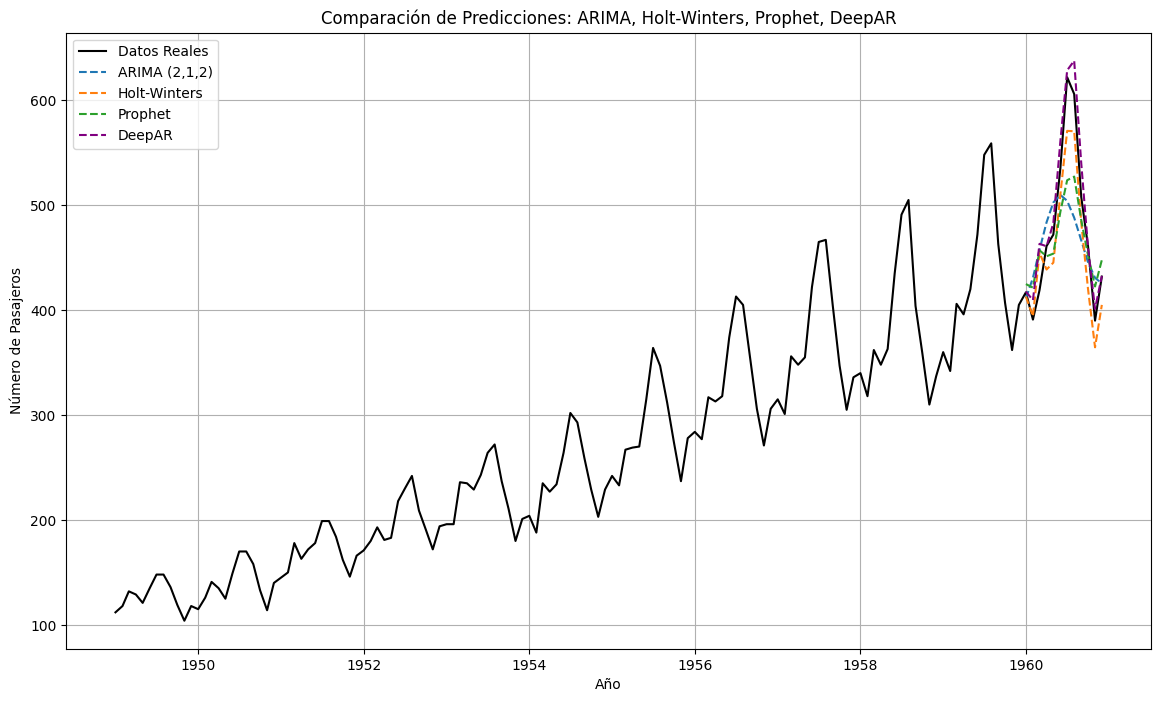

RMSE ARIMA: 55.22
RMSE Holt-Winters: 29.74
RMSE Prophet: 43.07
RMSE DeepAR: 21.05


In [16]:
# Librerías necesarias
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from gluonts.dataset.common import ListDataset
from gluonts.torch.model.deepar import DeepAREstimator
from gluonts.evaluation.backtest import make_evaluation_predictions
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore", message="No frequency information was provided")

# Cargar datos
data = pd.read_csv("AirPassengers.csv", parse_dates=["Month"])
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)
data['#Passengers'] = data['#Passengers'].astype(float)

# Dividir en entrenamiento (1949-1960) y validación (1960-1970)
train_data = data[data.index < "1960"]
test_data = data[data.index >= "1960"]

# 1. Modelo ARIMA
arima_model = ARIMA(train_data['#Passengers'], order=(2, 1, 2))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=len(test_data))

# 2. Modelo Holt-Winters
hw_model = ExponentialSmoothing(
    train_data['#Passengers'],
    seasonal='multiplicative',
    seasonal_periods=12
).fit()
hw_forecast = hw_model.forecast(len(test_data))

# 3. Modelo Prophet
prophet_data = train_data.reset_index().rename(columns={"Month": "ds", "#Passengers": "y"})
prophet_model = Prophet(yearly_seasonality=True)
prophet_model.fit(prophet_data)
future = prophet_model.make_future_dataframe(periods=len(test_data), freq='MS')
prophet_forecast = prophet_model.predict(future)
prophet_forecast = prophet_forecast[prophet_forecast['ds'] >= "1960"]['yhat']

# 4. Modelo DeepAR
train_ds = ListDataset(
    [{"start": train_data.index[0], "target": train_data['#Passengers']}],
    freq="M"
)
test_ds = ListDataset(
    [{"start": data.index[0], "target": data['#Passengers']}],
    freq="M"
)

deepar_estimator = DeepAREstimator(
    freq="M",
    prediction_length=len(test_data),
    trainer_kwargs={"max_epochs": 100, "accelerator": "cpu"}
)
deepar_predictor = deepar_estimator.train(train_ds)

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=deepar_predictor,
    num_samples=100
)
forecasts = list(forecast_it)
deepar_forecast = forecasts[0].mean_ts

# Comparación de predicciones
plt.figure(figsize=(14, 8))
plt.plot(data.index, data['#Passengers'], label="Datos Reales", color="black")
plt.plot(test_data.index, arima_forecast, label="ARIMA (2,1,2)", linestyle='--')
plt.plot(test_data.index, hw_forecast, label="Holt-Winters", linestyle='--')
plt.plot(test_data.index, prophet_forecast.values, label="Prophet", linestyle='--')
plt.plot(test_data.index, deepar_forecast, label="DeepAR", linestyle='--', color="purple")
plt.title("Comparación de Predicciones: ARIMA, Holt-Winters, Prophet, DeepAR")
plt.xlabel("Año")
plt.ylabel("Número de Pasajeros")
plt.legend()
plt.grid()
plt.show()

# Métricas de evaluación (RMSE)
arima_rmse = np.sqrt(mean_squared_error(test_data['#Passengers'], arima_forecast))
hw_rmse = np.sqrt(mean_squared_error(test_data['#Passengers'], hw_forecast))
prophet_rmse = np.sqrt(mean_squared_error(test_data['#Passengers'], prophet_forecast))
deepar_rmse = np.sqrt(mean_squared_error(test_data['#Passengers'], deepar_forecast))

print(f"RMSE ARIMA: {arima_rmse:.2f}")
print(f"RMSE Holt-Winters: {hw_rmse:.2f}")
print(f"RMSE Prophet: {prophet_rmse:.2f}")
print(f"RMSE DeepAR: {deepar_rmse:.2f}")